In [310]:
import pandas as pd
import numpy as np 
import seaborn as sn 
import matplotlib.pyplot as plt
from collections import Counter
plt.style.use("dark_background")
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, confusion_matrix, f1_score, accuracy_score, recall_score, classification_report, roc_auc_score

from utils import DataLoader, DataProcesser, label_plot

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [256]:
label_dic = {1: 'Still', 2: 'Walking', 3: 'Run', 4: 'Bike', 5: 'Car', 6: 'Bus', 7: 'Train', 8: 'Subway'}

# Data

## Train-Test

In [257]:
df = pd.read_csv("data/mid_res/data_ft_v1.csv").fillna(0)
col_drop_x = ['time', 'label']

In [262]:
df['speed_log'] = df.apply(lambda x: np.log(x['speed'] + 1), axis = 1) # 运行一遍
df['acc_wd_std'] = df[['label', 'acc']].rolling(10).std()['acc']

In [289]:
col_drop = ['latitude',
 'longitude',
 'altitude',
 'time_dlt',
 'valid_dlt',
 'east',
 'north',
 'east_dlt',
 'north_dlt',
 'east_speed',
 'north_speed',
 'cells_ctype_mode',
 'speed_dif',
 'speed_dlt',
 'speed' # 使用 speed_log
 ]

In [290]:
list(df.drop(col_drop, axis = 1))

['time',
 'label',
 'accuracy',
 'num_gps',
 'num_wifi',
 'num_cells',
 'acc',
 'wifi_rssi_mode',
 'wifi_rssi_mean',
 'wifi_rssi_min',
 'wifi_rssi_max',
 'wifi_rssi_std',
 'wifi_freq_5ratio',
 'cells_isRegistered_mean',
 'cells_asuLevel_mean',
 'cells_dbm_mean',
 'cells_level_mean',
 'cells_asuLevel_min',
 'cells_dbm_min',
 'cells_level_min',
 'cells_asuLevel_max',
 'cells_dbm_max',
 'cells_level_max',
 'cells_asuLevel_std',
 'cells_dbm_std',
 'gps_snr_mean',
 'gps_snr_min',
 'gps_snr_max',
 'gps_snr_std',
 'speed_log',
 'acc_wd_std']

In [291]:
test_ratio = 0.2
X = df.drop(col_drop_x + col_drop, axis = 1).fillna(0)

In [292]:
# sequence
# len_train = int(X.shape[0] * train_ratio)
# len_test = X.shape[0] - len_train
# X_train, X_test, y_train, y_test = X.iloc[:len_train,:], X.iloc[-len_test:,:], df['label'][:len_train], df['label'][-len_test:]
# random split
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size = test_ratio)

## Validate

In [334]:
# val = DataLoader.SHLDataLoader('data/validate/')
# val.load_all()
# dp_val = DataProcesser.DataProcesser(val)
# dp_val.process_pipe()

# val['speed_log'] = val.apply(lambda x: np.log(x['speed'] + 1), axis = 1)
# val['acc_wd_std'] = val[['label', 'acc']].rolling(10).std()['acc']

In [ ]:
# save
# file = open('data/mid_res/val_ft.pickle', 'wb')
# pickle.dump(val, file)
# file.close()
# load
with open('data/mid_res/val_ft.pickle', 'rb') as file:
    val = pickle.load(file)

---
# Model

## Random Forest

In [349]:
rf = RandomForestClassifier(n_estimators = 20, random_state = 0, max_depth = 8)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test) # label predict
pred_prob_rf = rf.predict_proba(X_test) # prob predict

## Xgboost

---
# Evaluation

## Test DataSet-Top1

In [296]:
pred = pred_rf
print("macro score: {}\nmicro score: {}\nweighted score: {}".format(precision_score(y_test, pred, average = "macro"),
                                                                    precision_score(y_test, pred, average = "micro"),
                                                                    precision_score(y_test, pred, average = "weighted")))
conf = confusion_matrix(y_test, pred)
conf

macro score: 0.751969453498263
micro score: 0.7206714735908132
weighted score: 0.7312063314561851


array([[19092,   891,     1,   192,   519,  1339,   947,  1131],
       [ 1207, 19186,   216,  1214,   274,  1387,   562,   901],
       [   17,  2028,  3758,  2105,    16,   523,     4,     2],
       [  236,  1229,    74, 18761,   830,  2287,    45,    20],
       [  571,   209,    20,  2280, 22311,  3903,  2419,   250],
       [  859,   298,     8,  1494,  2532, 19958,  3117,   168],
       [ 1604,    58,     1,   501,  3947,  4228, 19689,  1155],
       [  810,   137,    13,   280,  1169,  1357,  1193, 18573]])

<AxesSubplot:>

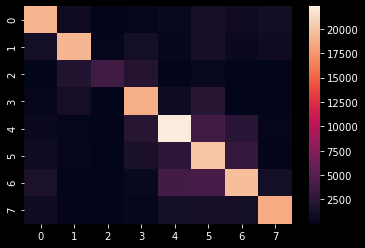

In [297]:
sn.heatmap(conf)

In [298]:
print(classification_report(y_test, pred, target_names = list(label_dic.values())))

              precision    recall  f1-score   support

       Still       0.78      0.79      0.79     24112
     Walking       0.80      0.77      0.78     24947
         Run       0.92      0.44      0.60      8453
        Bike       0.70      0.80      0.75     23482
         Car       0.71      0.70      0.70     31963
         Bus       0.57      0.70      0.63     28434
       Train       0.70      0.63      0.67     31183
      Subway       0.84      0.79      0.81     23532

    accuracy                           0.72    196106
   macro avg       0.75      0.70      0.72    196106
weighted avg       0.73      0.72      0.72    196106



## Test DataSet-Top2

In [300]:
pred_prob = pred_prob_rf
df1 = pd.DataFrame(pred_prob, columns = list(label_dic.values()))
df2 = pd.DataFrame({"label": y_test})
y_test_compare = pd.concat([df1.reset_index(drop = True), df2.reset_index(drop = True)], axis = 1, ignore_index = False)

In [301]:
def top(x, n):
    return x.sort_values().to_list()[-n]

pred_df = pd.concat([df1.reset_index(drop = True), df2.reset_index(drop = True)], axis = 1, ignore_index = False)
pred_df['pred_top1'] = df1.apply(lambda x: np.where(x == top(x, n = 1))[0][0] + 1, axis = 1)
pred_df['pred_top2'] = df1.apply(lambda x: np.where(x == top(x, n = 2))[0][0] + 1, axis = 1)
pred_df['hit_top1'] = pred_df.apply(lambda x: int(x['pred_top1'] == x['label']), axis = 1)
pred_df['hit_top2'] = pred_df.apply(lambda x: int((x['pred_top1'] == x['label']) | (x['pred_top2'] == x['label'])), axis = 1)

pred_df['hit_top1'] = pred_df.apply(lambda x: int(x['pred_top1'] == x['label']), axis = 1)
pred_df['hit_top2'] = pred_df.apply(lambda x: int((x['pred_top1'] == x['label']) | (x['pred_top2'] == x['label'])), axis = 1)
# pred_df.to_csv('data/mid_res/pred_v1.csv', header = True, index = False)

In [324]:
print("Top 1 precision: {}\nTop 2 precesion: {}".format(Counter(pred_df.hit_top1)[1]/np.sum(list(Counter(pred_df.hit_top1).values())),
                                                roc_auc_score(y_test, pred_prob_rf, multi_class = 'ovo')))

In [351]:
roc_auc_score(y_test, pred_prob_rf, multi_class = 'ovo')

0.9501275730029606

In [305]:
# random forest
ft_df = pd.DataFrame({"Feature": list(X), "Importance": rf.feature_importances_})
ft_df.sort_values(ascending = False, by = "Importance", inplace = True)

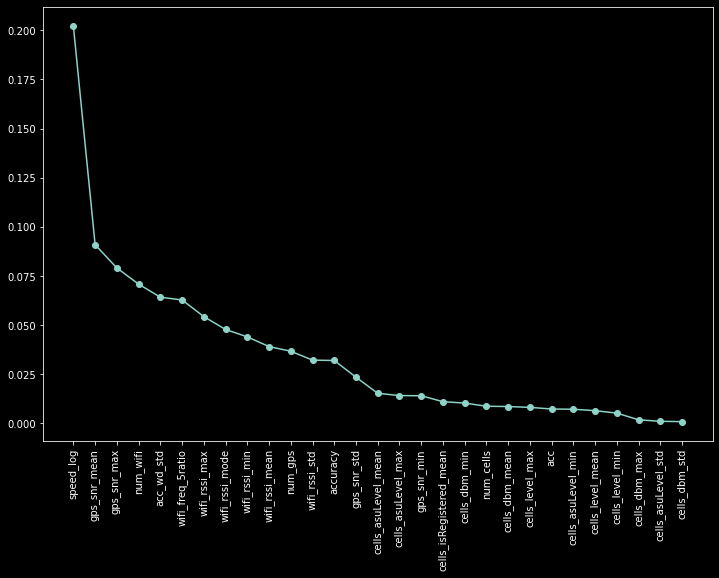

In [307]:
# feature importance
plt.figure(figsize = [12, 8])
plt.plot(ft_df['Importance'].reset_index(drop = True))
plt.scatter(range(ft_df.shape[0]), ft_df['Importance'].reset_index(drop = True))
plt.xticks(range(ft_df.shape[0]), ft_df['Feature'].reset_index(drop = True), rotation = 90);

## Validation DataSet

In [352]:
# load
with open('data/mid_res/val_ft.pickle', 'rb') as file:
    val = pickle.load(file)

In [353]:
X_val = val.df.drop(col_drop_x + col_drop, axis = 1).fillna(0)
pred_rf_val = rf.predict(X_val)
pred_prob_rf_val = rf.predict_proba(X_val)

In [354]:
pred = pred_rf_val
print(classification_report(val.df['label'], pred, target_names = list(label_dic.values())))

              precision    recall  f1-score   support

       Still       0.56      0.35      0.43     29836
     Walking       0.76      0.39      0.52     26149
         Run       0.07      0.00      0.01      2774
        Bike       0.56      0.71      0.63     12031
         Car       0.51      0.43      0.47     20473
         Bus       0.20      0.58      0.29      9178
       Train       0.42      0.51      0.47     21808
      Subway       0.67      0.79      0.72     21709

    accuracy                           0.50    143958
   macro avg       0.47      0.47      0.44    143958
weighted avg       0.55      0.50      0.50    143958



In [355]:
conf = confusion_matrix(val.df['label'], pred)
conf

array([[10380,  1088,     0,   401,   477,  6638,  7455,  3397],
       [ 2305, 10213,    35,  1967,   924,  8115,  1190,  1400],
       [    6,   234,    13,  1297,    53,  1166,     0,     5],
       [  489,  1420,   130,  8598,     4,    30,    35,  1325],
       [  550,   240,     3,  2711,  8790,  4029,  3428,   722],
       [ 1776,   130,     8,   306,    71,  5282,   948,   657],
       [ 2632,     7,     0,   177,  5545,  1108, 11200,  1139],
       [  492,   181,     0,    22,  1206,   536,  2106, 17166]])

<AxesSubplot:>

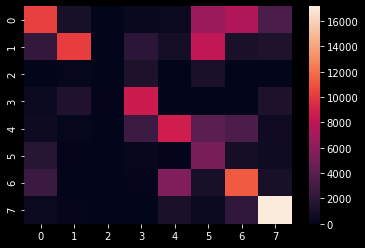

In [356]:
sn.heatmap(conf)